## importing essential libraries

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt

## loading the dataset (v1.1)

In [ ]:
path = "/content/drive/My Drive/Datasets/canine_dataset/canine_chemical_dataset_v1.1.csv"
dataset = pd.read_csv(filepath_or_buffer=path)

dataset.head()

,Num,ID,Species,Age,Sex,A:G Ratio,ALT,Albumin,Alk Phos,Amylase,Anion Gap,Bicarbonate,CK,Calcium,Chloride,Cholesterol,Creatinine,Direct Bilirubin,GGT,GLDH,Globulin,Glucose,Hemolysis,Indirect Bilirubin,Lipase,Lipemia,Magnesium,Na:K Ratio,Phosphorus,Potassium,Sodium,Total Bilirubin,Total Protein,Urea,Yellow,3rd space losses,AG acidosis,AG elevated,AG lowered,ALP elvated,...,Polycystic kidney,Portosystemic circulation,Portosystemic shunt,Post-prandial,Post-prandial elevation,Pre bile acids elevated,Pre/post BA WNL,Protein-losing enteropathy,Proteinuria,Psychogenic,Ratio elevated,Red blood cell elevated,Renal acid retention,Renal albumin lowered,Renal clearance lowered,Renal disease,Renal failure,Renal insufficiency,Renal losses,Renal protein loss,Renal proteinuria,Respiratory acidosis,Retention ketoacids,Sarcopenia,Selective hypochloremia,Sepsis,Sodium elevated,Steroid-induction,Sub-optimal mineralocorticoid supplementation,Systemic inflammation,Toxicity,Tubulointerstitial disease,UPC elevated,UPC lowered,UTI,Urea elevated,Urea lowered,Volume contraction,Volume depletion,hepatocellular injury
0,0,PDS1900006,"Shepherd, German (C)",10.0,Neutered Male,None,133,42,63,687,28,18,702,2.74,112,6.77,86,0.5,0,20,29,3.1,1+,0.9,56,Slight,0.83,31,1.41,4.9,153,1.4,71,9.4,None,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,PDS1900016,Bichon Frise (C),13.0,Neutered Male,0.91,90,31,97,1153,20,22,125,2.62,113,6.04,78,0.7,3,17,34,5.9,None,0.5,97,None,0.77,31,1.2,4.9,150,1.2,65,6.8,None,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2,PDS1900047,Rottweiller X (C),1.0,Male,0.66,41,31,110,864,20,21,371,2.65,110,4.59,60,0.1,0,11,47,5.3,1+,1.9,12,None,0.76,33,1.67,4.4,147,2,78,3.8,None,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,PDS1900049,"Terrier, Wheaten (C)",11.0,Spayed Female,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,PDS1900054,"Shepherd, German X (C)",6.0,Spayed Female,0.87,147,33,262,660,20,20,182,2.58,117,4.61,88,1.2,5,21,38,5.7,None,0.7,31,None,0.82,34,0.97,4.5,152,1.9,71,5.7,None,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
dataset = dataset.drop(columns=['Num', 'ID'])
features = dataset.iloc[:, :33]
labels = dataset.iloc[:, 33:]
 
print(features.head())
print('----------------------------------------------------------')
print(labels.head())

                   Species   Age            Sex  ... Total Protein  Urea Yellow
0    Shepherd, German  (C)  10.0  Neutered Male  ...            71   9.4   None
1         Bichon Frise (C)  13.0  Neutered Male  ...            65   6.8   None
2       Rottweiller X  (C)   1.0           Male  ...            78   3.8   None
3     Terrier, Wheaten (C)  11.0  Spayed Female  ...          None  None   None
4  Shepherd, German X  (C)   6.0  Spayed Female  ...            71   5.7   None

[5 rows x 33 columns]
----------------------------------------------------------
   3rd space losses  AG acidosis   ...  Volume depletion  hepatocellular injury
0                 0             0  ...                 0                      0
1                 1             0  ...                 0                      0
2                 1             0  ...                 0                      0
3                 0             0  ...                 0                      0
4                 0             0  ...

## handling missing data: deletion

<center><img src="https://miro.medium.com/max/1050/1*_RA3mCS30Pr0vUxbp25Yxw.png" width=600></center>
<center>General plan for handling missing data</center>

In [ ]:
# columnwise deletion: delete columns which have None/NaN/Unknown values for more than
# 0.25 * len(dataset) records in the dataset
print('num columns before pruning:', len(dataset.columns))

columns_to_be_removed = list()
pruned_dataset = copy.deepcopy(dataset)
for label, column in features.iteritems():
    num_nones = 0
    for element in column:
        if element == 'None' or element != element or element == 'Unknown': # check if element is None or NaN or Unknown
            num_nones += 1
    if num_nones >= 0.25 * len(pruned_dataset):
        columns_to_be_removed.append(label)

print('column labels to be removed:', columns_to_be_removed)
pruned_dataset = pruned_dataset.drop(columns=columns_to_be_removed, axis=1)
print('num columns after pruning:', len(pruned_dataset.columns))
print('columnwise deletion done!')

# update 'features' dataframe
features = pruned_dataset.iloc[:, :len(features.columns) - len(columns_to_be_removed)]

num columns before pruning: 247
column labels to be removed: ['Hemolysis', 'Lipemia', 'Yellow']
num columns after pruning: 244
columnwise deletion done!


num records before pruning: 4067
num records after pruning with threshold of 0.05: 3319
num records after pruning with threshold of 0.10: 3327
num records after pruning with threshold of 0.15: 3327
num records after pruning with threshold of 0.20: 3328
num records after pruning with threshold of 0.25: 3330
num records after pruning with threshold of 0.30: 3330
num records after pruning with threshold of 0.35: 3330
num records after pruning with threshold of 0.40: 3330
num records after pruning with threshold of 0.45: 3671
num records after pruning with threshold of 0.50: 3701
num records after pruning with threshold of 0.55: 3703
num records after pruning with threshold of 0.60: 3704
num records after pruning with threshold of 0.65: 3704
num records after pruning with threshold of 0.70: 3704
num records after pruning with threshold of 0.75: 3704
num records after pruning with threshold of 0.80: 3726
num records after pruning with threshold of 0.85: 3732
num records after pruning with t

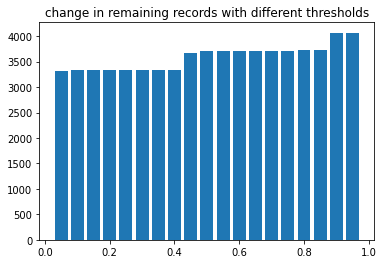

In [ ]:
# listwise deletion: delete rows with None/NaN values higher than thresh * len(row)
# let's find the most optimum value for "thresh"
print('num records before pruning:', len(pruned_dataset))
remaining_recs = list()
for thresh in np.arange(0.05, 1.0, 0.05):
    tot_pruned_dataset = copy.deepcopy(pruned_dataset)
    for idx, row in features.iterrows():
        num_nones = 0
        for element in row:
            if element == 'None' or element != element or element == 'Unknown': # if element is None or NaN or Unknown
                num_nones += 1
        # print('row %d has %d Nones' %(idx, num_nones))
        if num_nones >= thresh * len(row):
            tot_pruned_dataset = tot_pruned_dataset.drop(pruned_dataset.index[idx])
            # print('record num %d deleted!' % idx)
    print('num records after pruning with threshold of %.2f: %d' % (thresh, len(tot_pruned_dataset)))
    remaining_recs.append(len(tot_pruned_dataset))

print('----------------------------------------------------------')
plt.bar(x=np.arange(0.05, 1.0, 0.05), height=remaining_recs, width=0.04)
plt.title('change in remaining records with different thresholds')
plt.show()
# most optimum threshold seems to be 0.4

In [ ]:
best_thresh = 0.4
print('num records before pruning:', len(pruned_dataset))
tot_pruned_dataset = copy.deepcopy(pruned_dataset)
for idx, row in features.iterrows():
    num_nones = 0
    for element in row:
        if element == 'None' or element != element or element == 'Unknown': # if element is None or NaN or Unknown
            num_nones += 1
    if num_nones >= best_thresh * len(row):
        tot_pruned_dataset = tot_pruned_dataset.drop(pruned_dataset.index[idx])

print('num records after optimal pruning:', len(tot_pruned_dataset))
print('listwise deletion done!')

num records before pruning: 4067
num records after optimal pruning: 3330
listwise deletion done!


In [ ]:
# next we have imputation: since our data is not time-series, we must perform general imputation. 
# we only have 2 categorical features: 'species' and 'sex'. Only the latter one has missing data.

# The problem is that there is barely a relation between canine 'sex' and other features,
# hence, we may delete the records, impute them completely random, or find records with similar 
# specie and impute the missing 'sex' value with the most occuring type of similar breed
imputed_dataset = copy.deepcopy(tot_pruned_dataset)

for idx, row in tot_pruned_dataset.iterrows():
    if row[2] != row[2] or row[2] == 'Unknown': # find records with missing 'sex' column
        breed = row[0]
        sex_vals = list()
        for _, l_row in tot_pruned_dataset.iterrows():
            if l_row[0] == breed:
                sex_vals.append(l_row[2])
        sex_vals = [e for e in sex_vals if e == e and e != 'Unknown'] # remove original nan/unknown val
        if len(sex_vals) == 0: # remove record if there are only nan/unknown sex vals for it
            imputed_dataset = imputed_dataset.drop(idx)
        else:
            most_freq_sex = max(set(sex_vals), key=sex_vals.count) # find most freq sex for certain breed
            imputed_dataset.at[idx, 'Sex'] = most_freq_sex # replace the imputed val
        # break
print('imputing "sex" values done!')
imputed_dataset = imputed_dataset.reset_index(drop=True) # reset dataset indices
print('resetting manipulated dataset record indices done!')

imputing "sex" values done!
resetting manipulated dataset record indices done!


## classifying canine breeds into major categories

num unique species: 235


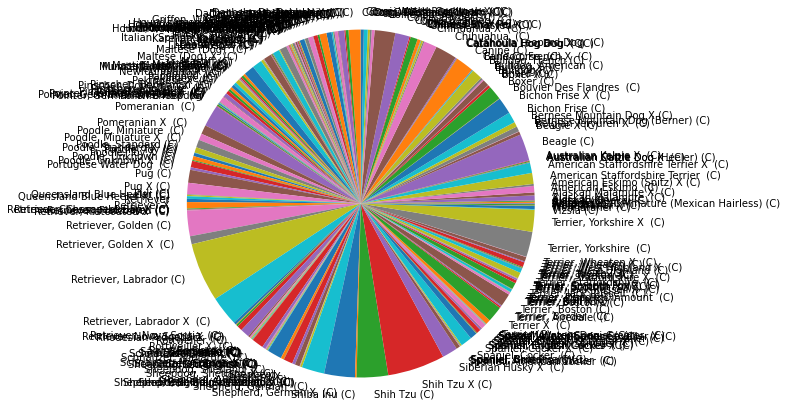

In [ ]:
# here we need to look at canine 'species' column since there are many breeds available
# and we may categorize them into smaller number of classes to decrease model inputs
species = imputed_dataset.loc[:, 'Species']
unique_species = np.unique(species)
print('num unique species:', len(unique_species))

species_freq = list()
for specie in unique_species:
    specie_repeat = 0
    for idx, row in imputed_dataset.iterrows():
        if row[0] == specie:
            specie_repeat += 1
    species_freq.append(specie_repeat)
# print(species_freq)

plt.pie(x=species_freq, labels=unique_species, radius=2)
plt.show()

In [ ]:
# we need to decrease the number of categories related to canine species
# a possible solution is to find hierarchies and bundle each couple of species 
# under one generic category

# AKC (American Kernel Club): 1. Herding(31) 2. Sporting(32) 3. Non-sporting(20) 4. Working(31)
# 5. Hound(32) 6. Terrier(31) 7. Toy(21) 8. FSS(67) 9. Misc.(11)  ---> Totally: 276 types

# we need to write a scraper to get the data from the site and build our group lists
# https://www.akc.org/public-education/resources/general-tips-information/dog-breeds-sorted-groups/

import requests
import bs4
import lxml.etree as xml

URL = "https://www.akc.org/public-education/resources/general-tips-information/dog-breeds-sorted-groups/"
requests.get(url=URL)
web_page = bs4.BeautifulSoup(markup=requests.get(url=URL).text, features="lxml")

canine_breed_dict = dict()
sub_wp = web_page.find_all(name="div", attrs={"class": "content-accordion__content animated-height"})

for wp in sub_wp:
    breed_category = wp.find_all(name='p')[0].text
    canine_breed_dict[breed_category] = []
    breeds = wp.findChildren(name='li', attrs={})
    for breed in breeds:
        canine_breed_dict[breed_category].append(breed.text)

In [ ]:
from IPython.lib.pretty import pprint

# merge Misc. with FSS, since they are actually the same, according to AKC
canine_breed_dict['FOUNDATION STOCK SERVICE'].extend(canine_breed_dict['MISCELLANEOUS CLASS'])
canine_breed_dict.pop('MISCELLANEOUS CLASS')

pprint(canine_breed_dict, newline='\n', max_seq_length=9)

{'FOUNDATION STOCK SERVICE': ['American Bulldog',
  'American Leopard Hound',
  'Appenzeller Sennenhund',
  'Australian Kelpie',
  'Australian Stumpy Tail Cattle Dog',
  'Basset Fauve de Bretagne',
  'Bavarian Mountain Scent Hound',
  'Bohemian Shepherd',
  'Bolognese',
  ...],
 'HERDING GROUP': ['Australian Cattle Dog',
  'Australian Shepherd',
  'Bearded Collie',
  'Beauceron',
  'Belgian Laekenois',
  'Belgian Malinois',
  'Belgian Sheepdog',
  'Belgian Tervuren',
  'Bergamasco',
  ...],
 'HOUND GROUP': ['Afghan Hound',
  'American English Coonhound',
  'American Foxhound',
  'Azawakh',
  'Basenji',
  'Basset Hound',
  'Beagle',
  'Black and Tan Coonhound',
  'Bloodhound',
  ...],
 'NON-SPORTING GROUP': ['American Eskimo Dog',
  'Bichon Frise',
  'Boston Terrier',
  'Bulldog',
  'Chinese Shar-Pei',
  'Chow Chow',
  'Coton De Tulear',
  'Dalmatian',
  'Finnish Spitz',
  ...],
 'SPORTING GROUP': ['American Water Spaniel',
  'Barbet',
  'Boykin Spaniel',
  'Brittany',
  'Chesapeake Bay

In [ ]:
import re


def clean_breed_name(name):
    name = name.replace(' (C)', '') # remove 'C' for canine, since all are dogs
    name = name.replace(' X', '') # remove 'X' at the end of some names
    name = name.replace('-', ' ') # replace any dashes with space
    name = ' '.join([e.strip() for e in reversed(name.split(','))]) # reformat to be general
    for c in '()': name = name.replace(c, '') # remove paranthesis
    name = re.compile(pattern=' dog', flags=re.IGNORECASE).sub('', name) # remove general word
    name = re.compile(pattern='miniature ', flags=re.IGNORECASE).sub('', name) # remove general word
    # there are some discrepancies we need to address; some names are not standard
    if name == 'Queensland Blue Heeler': # were called in 1940s lol
        name = 'Australian Cattle'
    if name == 'Akbash': # not recognized by AKC. closet breed is anatolian shepherd
        name = 'Anatolian Shepherd'
    return name


# clean every breed name in the extracted dict from the website
for group in canine_breed_dict.keys():
    for idx, breed in enumerate(canine_breed_dict[group]):
        canine_breed_dict[group][idx] = clean_breed_name(canine_breed_dict[group][idx])

# clean every breed name in the species column of the dataset
for idx, breed in enumerate(species):
    species[idx] = clean_breed_name(breed)

In [ ]:
import nltk


def calculate_similarity(base, temp):
    dist = nltk.edit_distance(base, temp)
    splitted_dist = nltk.edit_distance(base.split(), temp.split())
    is_same = int(sorted(base.split()) == sorted(temp.split()))
    is_subset = int(int((base in temp) or (temp in base)))
    return dist + splitted_dist + 5*(1 - is_same) + 7*(1 - is_subset)


distances = dict()
for idx, breed in enumerate(species):
    for group in canine_breed_dict.keys():
        distances[group] = list()
        for st_breed in canine_breed_dict[group]:
            distances[group].append(calculate_similarity(breed, st_breed)) # calculate similarity
    distance_vals = list(distances.values())
    target_class = min(distance_vals, key=lambda x: min(x)) # find the list containing global min
    target_class_idx = distance_vals.index(target_class)
    # target_breed_idx = np.argmin(target_class)
    # target_breed = list(canine_breed_dict.items())[target_class_idx][1][target_breed_idx]

    imputed_dataset.at[idx, 'Species'] = list(canine_breed_dict.keys())[target_class_idx]
    # break

num unique species: 8


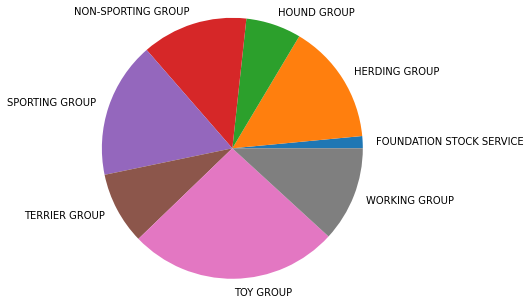

In [ ]:
# let's look at the canine categorization result based on AKC classes
unique_species = np.unique(species)
print('num unique species:', len(unique_species))

species_freq = list()
for specie in unique_species:
    specie_repeat = 0
    for idx, row in imputed_dataset.iterrows():
        if row[0] == specie:
            specie_repeat += 1
    species_freq.append(specie_repeat)
# print(species_freq)

plt.pie(species_freq, labels=unique_species, radius=1.5)
plt.show()

## handling missing data: deletion

In [ ]:
# on next, we have to do the continuous imputation over the None/Nan cells in numerical
# features. We use the closest record's value as the main method of replacement
from scipy import spatial
tot_imputed_dataset = copy.deepcopy(imputed_dataset)
features = imputed_dataset.iloc[:, :30]


def find_similar_rows(breed, sex, target_idx, dataset):
    similar_rows = list()
    similar_row_indices = list()
    for r_idx, row in dataset.iloc[:, :30].iterrows():
        if row[0] == breed and row[2] == sex:
            if row[target_idx] == 'None' or row[target_idx] != row[target_idx]:
                target_row = row
                target_row_idx = r_idx
                nan_idx = target_idx
                nan_cols = [row.keys()[target_idx]]
            else:
                similar_rows.append(row)
                similar_row_indices.append(r_idx)
    
    for ir_idx, item in enumerate(target_row):
        if item == 'None' or item != item:
            if ir_idx != nan_idx:
                nan_cols.append(target_row.keys()[ir_idx])
    
    nan_cols.extend(['Sex', 'Species'])
    # print(target_row_idx)
    target_row = list(target_row.drop(nan_cols))
    similar_rows = [list(row.drop(nan_cols)) for row in similar_rows]

    cleaned_similar_rows = list()
    for s_row in similar_rows:
        for item in s_row:
            if item == 'None' or item != item:
                break
        else:
            cleaned_similar_rows.append(s_row)

    closest_row_idx = match_closest_to(target=target_row, base=cleaned_similar_rows)
    val = dataset.values[similar_row_indices[closest_row_idx]][target_idx]
    # print(val)
    dataset.at[target_row_idx, nan_cols[0]] = val

def match_closest_to(target, base):
    target = list(map(float, target))
    base = [list(map(float, row)) for row in base]
    distances = list()
    for row in base:
        distance = 1 - spatial.distance.cosine(target, row)
        distances.append(distance)
    # print(distances)
    # print('closest row has a cosine sim. of %.4f' % max(distances))
    return np.argmax(distances)


for r_idx, row in features.iterrows():
    for i_idx, item in enumerate(row):
        if item == 'None' or item != item: # find if the cell value is missing
            find_similar_rows(breed=row[0], sex=row[2], target_idx=i_idx, 
                              dataset=tot_imputed_dataset)
    # break

print('imputing missing values done!')

imputing missing values done!


## normalization

In [2]:
data = pd.read_csv("/content/canine_chemical_dataset_v1.5.csv") # previously stored checkpoint
normal_ranges = pd.read_csv("/content/reference_intervals.csv") # reference intervals (by PDS Inc.)

normal_ranges = normal_ranges.drop(columns=['Units', 'Units.1']).values

In [3]:
updated_ranges = list()
for target in data.columns[3:30]: # iterate over features that have reference intervals
    if target in normal_ranges[:, 0]:
        idx = np.where(normal_ranges[:, 0] == target)[0][0]
        updated_ranges.append(normal_ranges[idx])
updated_ranges = np.array(updated_ranges) # convert to numpy array
updated_ranges[:, 1] = updated_ranges[:, 1].astype('float') # lower boundaries are inserted in string format

In [4]:
def normalize(x, low, high):
    b = (low + high) / (2* (low - high))
    a = -2*b / (low + high)
    y = a*x + b
    y = [np.round(element, 4) for element in y]
    return np.array(y)

In [24]:
norm_data = np.copy(data.values)
column_idx = 3
for boundary in updated_ranges:
    norm_data[:, column_idx] = normalize(x=data.values[:, column_idx], low=boundary[1], high=boundary[2])
    column_idx += 1

norm_tanh_data = np.copy(norm_data)
norm_tanh_data[:,3:30] = np.tanh(norm_data[:,3:30].astype('float')) # apply tanh on the normalized data to fit into [0,1]

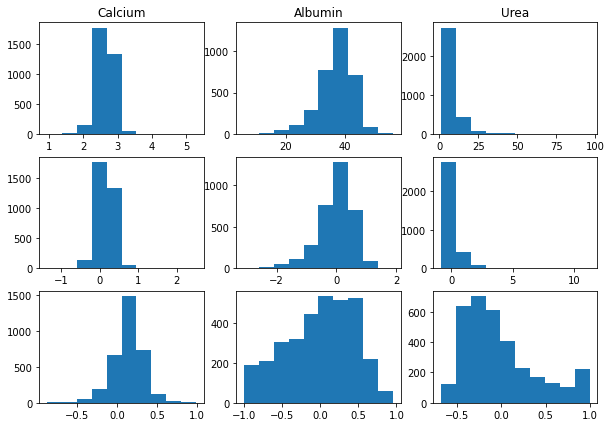

In [39]:
# let's see some of the histograms before/after tanh and normalization
indices = np.random.randint(3, 30, 3)
fig = plt.figure(figsize=(10, 7))
for i, idx in enumerate(indices):
    plt.subplot(3, 3, i+1)
    plt.hist(data.values[:, idx])
    plt.title(data.columns[idx])
    plt.subplot(3, 3, i+4)
    plt.hist(norm_data[:, idx])
    plt.subplot(3, 3, i+7)
    plt.hist(norm_tanh_data[:, idx])
plt.show()
# tanh and sigmoid as the activation function: tanh has significantly better distribution

## exporting the preprocessed dataset

In [40]:
# now that preprocessing part is finished, exported dataset is used for next phases
pd.DataFrame(norm_tanh_data).to_csv('/content/checkpoint.csv', index=False, na_rep='None')
print('successfully exported final dataset!')

successfully exported final dataset!
